In [26]:
from google.colab import drive
import numpy as np
import pandas as pd
import ast
from matplotlib import pyplot as plt

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# HotpotQA

In [2]:
file_path='/content/drive/MyDrive/ReAct experiments/hotpotQA_output_ReAct.txt'
data=[]
with open(file_path, 'r') as file:
  for line in file:
    line=line.strip()
    if line.startswith('{') and line.endswith('}'):
      try:
        data.append(ast.literal_eval(line))
      except Exception as e:
        print('Failed to read line')
        continue
df_react=pd.DataFrame(data)
df_react

,steps,answer,gt_answer,question_idx,reward,em,f1
0,3,1969,1972,3543,False,False,0.0
1,8,,James Taylor,1320,False,False,0.0
2,8,,1.5 million households,2811,False,False,0.0
3,3,"Based on the available information, it does no...",Nick Offerman,1885,False,False,0.0
4,3,1979,1967,4237,False,False,0.0
...,...,...,...,...,...,...,...
196,8,,Dirty Pretty Things,415,False,False,0.0
197,8,,Romantic comedy films,2474,False,False,0.0
198,8,,Wrath of Gods,4523,False,False,0.0
199,3,Test Icicles,X Ambassadors,433,False,False,0.0


In [3]:
file_path='/content/drive/MyDrive/ReAct experiments/hotpotQA_output_CoT.txt'
data=[]
with open(file_path, 'r') as file:
  for line in file:
    line=line.strip()
    if line.startswith('{') and line.endswith('}'):
      try:
        data.append(ast.literal_eval(line))
      except Exception as e:
        print('Failed to read line')
        continue
df_cot=pd.DataFrame(data)
df_cot

,answer,gt_answer,reward,em,f1,question_idx
0,1947,1972,False,False,0.0,3543
1,andrew preston,james taylor,False,False,0.0,1320
2,0,15 million households,False,False,0.0,2811
3,november,nick offerman,False,False,0.0,1885
4,2000,1967,False,False,0.0,4237
...,...,...,...,...,...,...
196,dirty pretty things,dirty pretty things,True,True,1.0,415
197,musical comedy,romantic comedy films,False,False,0.4,2474
198,wrath of gods,wrath of gods,True,True,1.0,4523
199,x ambassadors,x ambassadors,True,True,1.0,433


In [41]:
em_count=df_react['em'].sum()
em_ratio_react_qa=em_count/df_react.shape[0]
print(f'EM, ReAct: {em_ratio_react_qa} %')

EM, ReAct: 0.16417910447761194 %


In [42]:
em_count=df_cot['em'].sum()
em_ratio_cot_qa=em_count/df_cot.shape[0]
print(f'EM, CoT: {em_ratio_cot_qa} %')

EM, CoT: 0.17412935323383086 %


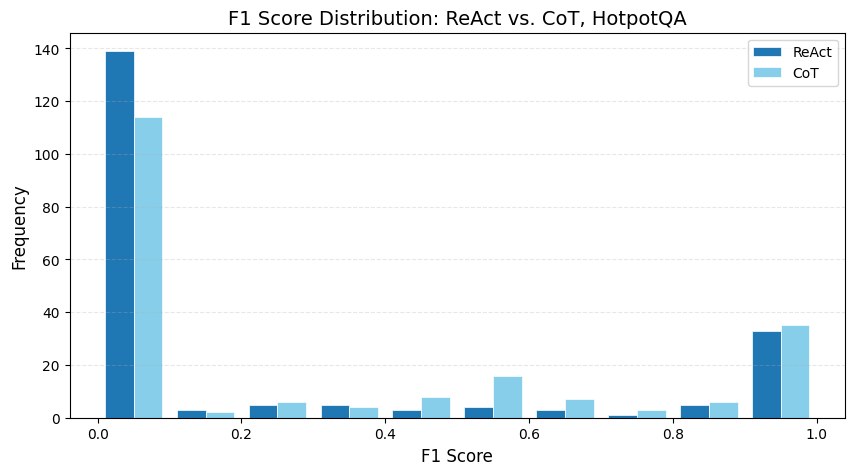

In [6]:
import matplotlib.pyplot as plt
import numpy as np

f1_react = df_react['f1']
f1_cot = df_cot['f1']

bin_width = 0.1
bins = np.arange(min(f1_react.min(), f1_cot.min()),
                 max(f1_react.max(), f1_cot.max()) + bin_width,
                 bin_width)

plt.figure(figsize=(10, 5))
plt.hist(
    [f1_react, f1_cot],
    bins=bins,
    label=['ReAct', 'CoT'],
    color=['#1f77b4', 'skyblue'],
    edgecolor='white',
    linewidth=0.5
)

plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('F1 Score Distribution: ReAct vs. CoT, HotpotQA', fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

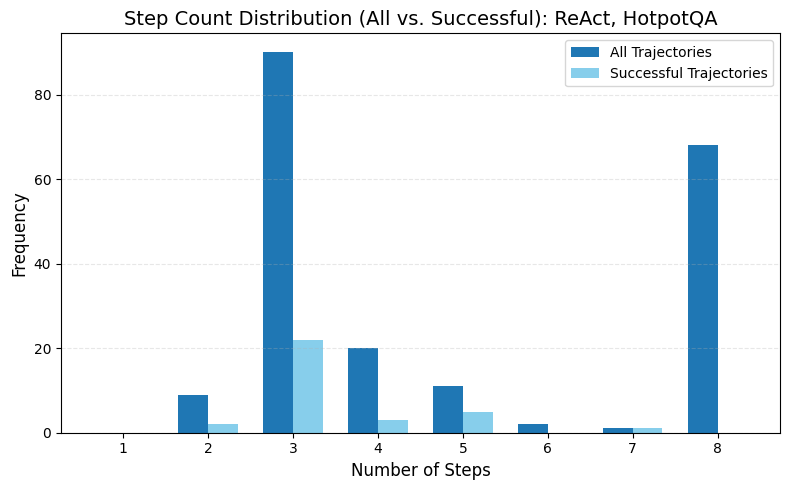

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Filter successful ReAct trajectories
df_react_true = df_react[df_react['em'] == True]

# Count step frequencies for successful and all trajectories
true_step_counts = df_react_true['steps'].value_counts().sort_index()
all_step_counts = df_react['steps'].value_counts().sort_index()

# Ensure both Series cover the full range of steps (1-8)
index = range(1, 9)
true_counts = [true_step_counts.get(i, 0) for i in index]
all_counts = [all_step_counts.get(i, 0) for i in index]

# Plot settings
x = np.arange(len(index))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, all_counts, width, label='All Trajectories', color='#1f77b4')
plt.bar(x + width/2, true_counts, width, label='Successful Trajectories', color='skyblue')

# Customize
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Step Count Distribution (All vs. Successful): ReAct, HotpotQA', fontsize=14)
plt.xticks(ticks=x, labels=index)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


=> When number of steps is more than 5, ReAct struggles to answer the question correctly.
Let's see what features may be correlated:

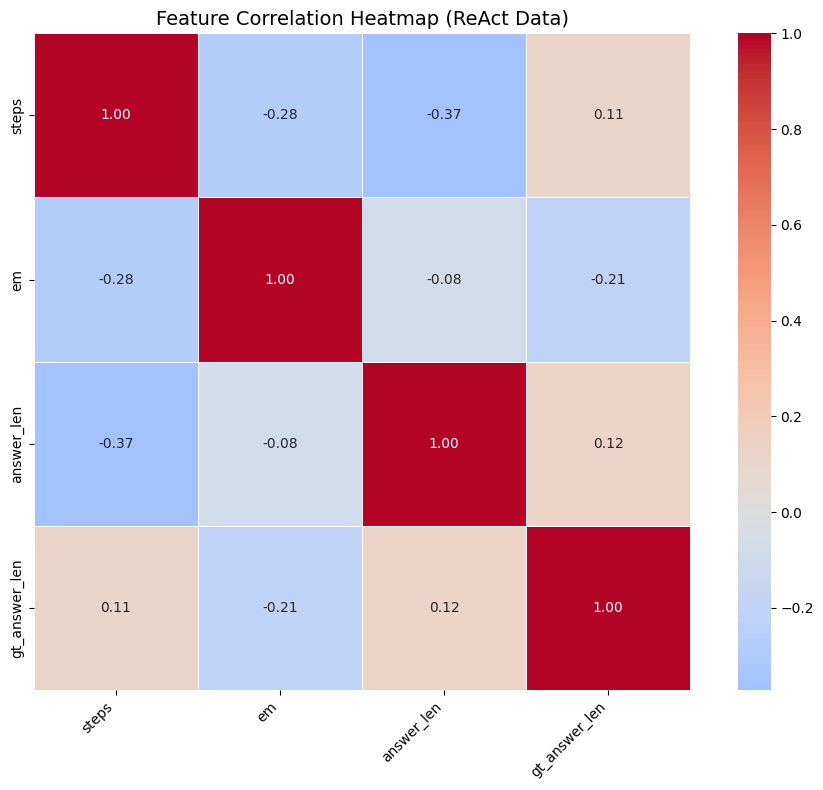

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
df_numeric = df_react[['steps', 'em']].copy()

# Optional: Encode 'answer'/'gt_answer' if they contain useful categorical info
# Example: Convert to string length or hash (simplistic approach)
df_numeric['answer_len'] = df_react['answer'].apply(len)
df_numeric['gt_answer_len'] = df_react['gt_answer'].apply(len)

# Compute correlation matrix
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,      # Show correlation values
    fmt=".2f",      # 2 decimal places
    cmap='coolwarm', # Blue (negative) to Red (positive)
    center=0,       # Neutral point at 0
    linewidths=0.5,
    square=True      # Force square plot
)

plt.title('Feature Correlation Heatmap (ReAct Data)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for readability
plt.tight_layout()  # Prevent label cutoff
plt.show()

Are steps and em/answer_len correlated?

In [13]:
from scipy.stats import pearsonr

# Calculate correlation and p-value
df_react['answer_len']=df_react['answer'].apply(len)
r, p = pearsonr(df_react['steps'], df_react['answer_len'])
r2, p2 = pearsonr(df_react['steps'], df_react['em'])
print(f'steps-answ_len: corr={r}, p={p}')
print(f'steps-em: corr={r2}, p={p2}')

steps-answ_len: corr=-0.37146643876785124, p=5.663263849502207e-08
steps-em: corr=-0.2777774585442321, p=6.538850644014555e-05


<ipython-input-14-d698aa163774>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


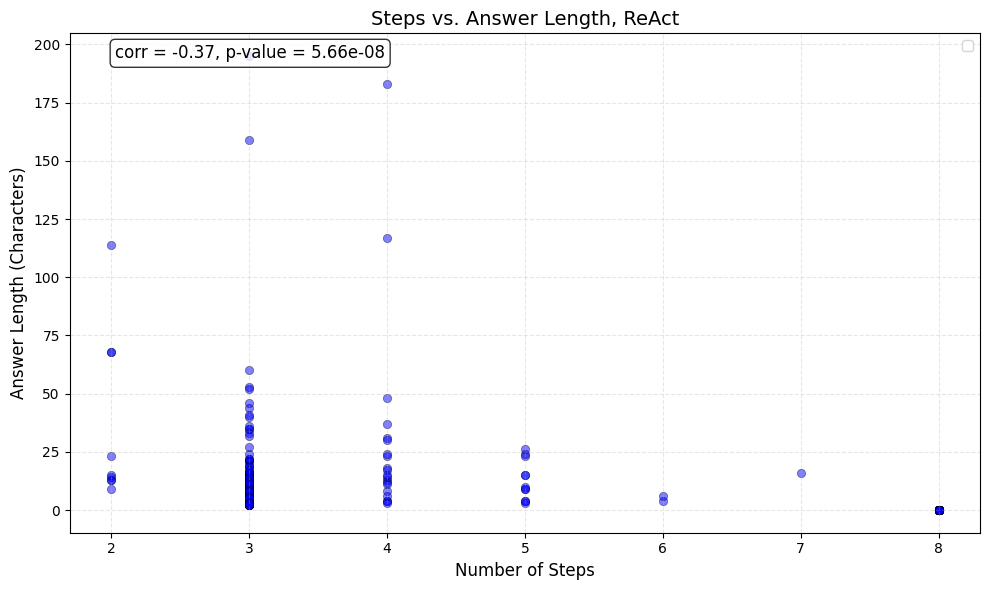

In [14]:
from scipy.stats import pearsonr

# Calculate correlation and p-value
r, p = pearsonr(df_react['steps'], df_react['answer_len'])

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(
    df_react['steps'],
    df_react['answer_len'],
    alpha=0.5,
    color='blue',
    edgecolor='black',
    linewidth=0.5
)

# Annotate correlation info
plt.text(
    0.05, 0.95,
    f'corr = {r:.2f}, p-value = {p:.2e}',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
)

# Customize
plt.title('Steps vs. Answer Length, ReAct', fontsize=14)
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Answer Length (Characters)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# FEVER

V1 - loops!

In [28]:
file_path='/content/drive/MyDrive/ReAct experiments/FEVER_output_ReAct_v1.txt'
data=[]
with open(file_path, 'r') as file:
  for line in file:
    line=line.strip()
    if line.startswith('{') and line.endswith('}'):
      try:
        data.append(ast.literal_eval(line))
      except Exception as e:
        print('Failed to read line')
        continue
bad_fever_react=pd.DataFrame(data)
bad_fever_react

,steps,answer,gt_answer,question_idx,em,reward,f1
0,8,,REFUTES,3687,0,0,0
1,8,,NOT ENOUGH INFO,6238,0,0,0
2,8,,REFUTES,5388,0,0,0
3,2,REFUTES,NOT ENOUGH INFO,3522,0,0,0
4,8,,SUPPORTS,3824,0,0,0
5,8,,REFUTES,2866,0,0,0
6,8,,REFUTES,1551,0,0,0
7,8,,REFUTES,2544,0,0,0
8,8,,NOT ENOUGH INFO,1557,0,0,0
9,8,,SUPPORTS,5762,0,0,0


In [33]:
em_react_bad=np.sum(bad_fever_react['em'])/bad_fever_react.shape[0]
print(f'FEVER (bad prompting) ReAct EM={em_react_bad} %') #more than random guessing!

FEVER (bad prompting) ReAct EM=0.0 %


In [34]:
bad_fever_react['answer'].value_counts()

,count
answer,
,15
REFUTES,1


Speed of answer generation: 0,17 answers per minute

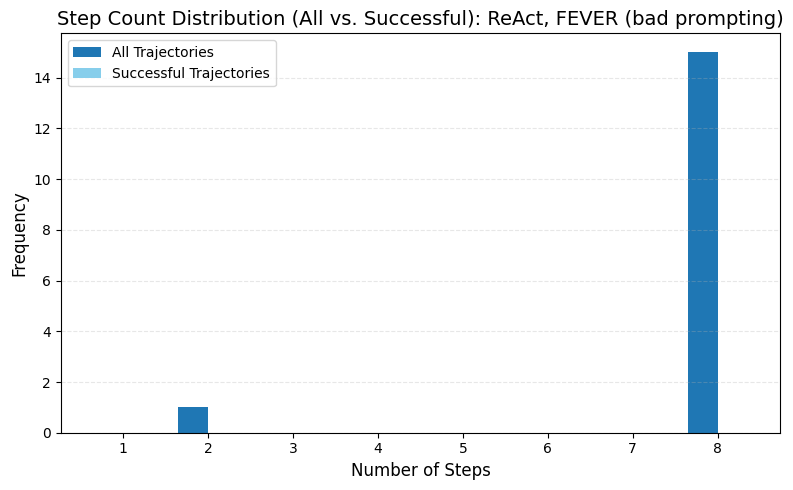

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Filter successful ReAct trajectories
bad_fever_react_true = bad_fever_react[bad_fever_react['em'] == True]

# Count step frequencies for successful and all trajectories
true_step_counts = bad_fever_react_true['steps'].value_counts().sort_index()
all_step_counts = bad_fever_react['steps'].value_counts().sort_index()

# Ensure both Series cover the full range of steps (1-8)
index = range(1, 9)
true_counts = [true_step_counts.get(i, 0) for i in index]
all_counts = [all_step_counts.get(i, 0) for i in index]

# Plot settings
x = np.arange(len(index))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, all_counts, width, label='All Trajectories', color='#1f77b4')
plt.bar(x + width/2, true_counts, width, label='Successful Trajectories', color='skyblue')

# Customize
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Step Count Distribution (All vs. Successful): ReAct, FEVER (bad prompting)', fontsize=14)
plt.xticks(ticks=x, labels=index)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


If we use altered prompt: initial prompt with examples + 'In the last line of your answer write only in format: Action i: Finish[], nothing else.', we get the speed of generation of 2,4 answers/min and better performance.

In [27]:
file_path='/content/drive/MyDrive/ReAct experiments/FEVER_output_ReAct_v2.txt'
data=[]
with open(file_path, 'r') as file:
  for line in file:
    line=line.strip()
    if line.startswith('{') and line.endswith('}'):
      try:
        data.append(ast.literal_eval(line))
      except Exception as e:
        print('Failed to read line')
        continue
df_fever_react=pd.DataFrame(data)
df_fever_react

,steps,answer,gt_answer,question_idx,em,reward,f1
0,1,NOT ENOUGH INFO,NOT ENOUGH INFO,4741,1,1,1
1,1,NOT ENOUGH INFO,SUPPORTS,6030,0,0,0
2,1,REFUTES,NOT ENOUGH INFO,5615,0,0,0
3,1,REFUTES,NOT ENOUGH INFO,5545,0,0,0
4,1,REFUTES,REFUTES,3653,1,1,1
...,...,...,...,...,...,...,...
196,1,NOT ENOUGH INFO,NOT ENOUGH INFO,7275,1,1,1
197,2,SUPPORTS,NOT ENOUGH INFO,7278,0,0,0
198,2,REFUTES,NOT ENOUGH INFO,5747,0,0,0
199,2,REFUTES,NOT ENOUGH INFO,3188,0,0,0


In [18]:
import re
file_path='/content/drive/MyDrive/ReAct experiments/FEVER_output_CoT.txt'
data=[]
with open(file_path, 'r') as file:
  for line in file:
    line=line.strip()
    line = re.sub(r'np\.int64\((\d+)\)', r'\1', line)
    if line.startswith('{') and line.endswith('}'):
      try:
        data.append(ast.literal_eval(line))
      except Exception as e:
        print(f'Failed to read line: {e}')
        print(line)
        break
df_fever_cot=pd.DataFrame(data)
df_fever_cot

,steps,answer,gt_answer,question_idx,em,reward,f1
0,1,NOT ENOUGH INFO,NOT ENOUGH INFO,4741,1,1,1
1,1,SUPPORTS,SUPPORTS,6030,1,1,1
2,2,,NOT ENOUGH INFO,5615,0,0,0
3,1,REFUTES,NOT ENOUGH INFO,5545,0,0,0
4,1,REFUTES,REFUTES,3653,1,1,1
...,...,...,...,...,...,...,...
196,1,SUPPORTS,NOT ENOUGH INFO,7275,0,0,0
197,1,SUPPORTS,NOT ENOUGH INFO,7278,0,0,0
198,1,REFUTES,NOT ENOUGH INFO,5747,0,0,0
199,2,,NOT ENOUGH INFO,3188,0,0,0


In [23]:
em_react=np.sum(df_fever_react['em'])/df_fever_react.shape[0]
print(f'FEVER React EM={em_react} %') #more than random guessing!

FEVER React EM=0.4527363184079602 %


In [24]:
em_cot=np.sum(df_fever_cot['em'])/df_fever_cot.shape[0]
print(f'FEVER CoT EM={em_cot} %')

FEVER CoT EM=0.3582089552238806 %


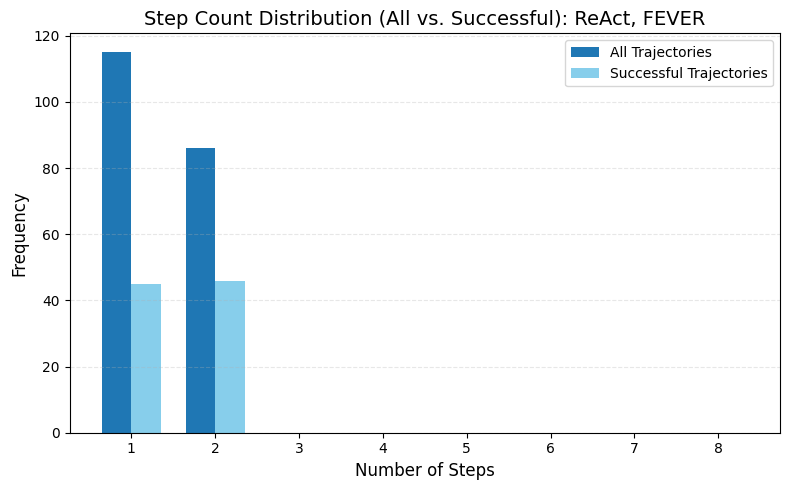

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Filter successful ReAct trajectories
df_fever_react_true = df_fever_react[df_fever_react['em'] == True]

# Count step frequencies for successful and all trajectories
true_step_counts = df_fever_react_true['steps'].value_counts().sort_index()
all_step_counts = df_fever_react['steps'].value_counts().sort_index()

# Ensure both Series cover the full range of steps (1-8)
index = range(1, 9)
true_counts = [true_step_counts.get(i, 0) for i in index]
all_counts = [all_step_counts.get(i, 0) for i in index]

# Plot settings
x = np.arange(len(index))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, all_counts, width, label='All Trajectories', color='#1f77b4')
plt.bar(x + width/2, true_counts, width, label='Successful Trajectories', color='skyblue')

# Customize
plt.xlabel('Number of Steps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Step Count Distribution (All vs. Successful): ReAct, FEVER', fontsize=14)
plt.xticks(ticks=x, labels=index)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


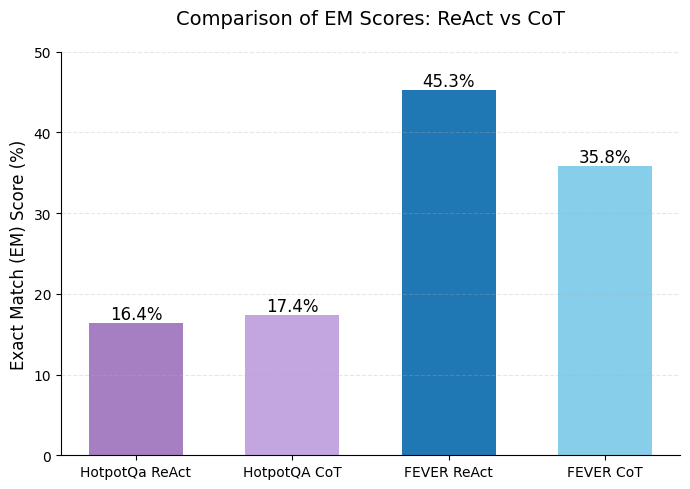

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['HotpotQa ReAct', 'HotpotQA CoT', 'FEVER ReAct', 'FEVER CoT']
em_scores = [em_ratio_react_qa, em_ratio_cot_qa, em_react, em_cot]  # as decimals
percent_scores = [x * 100 for x in em_scores]  # convert to percentages

# Create figure
plt.figure(figsize=(7, 5))

# Plot bars
bars = plt.bar(methods, percent_scores,
               color=['#A67FC2', '#C3A5E0', '#1f77b4', 'skyblue'],  # Blue and orange
               width=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

# Customize plot
plt.ylabel('Exact Match (EM) Score (%)', fontsize=12)
plt.title('Comparison of EM Scores: ReAct vs CoT', fontsize=14, pad=20)
plt.ylim(0, 50)  # Set y-axis limit to show difference clearly
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Remove top and right spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()